In [1]:
import os
import glob

import numpy as np
import pandas as pd
import parmed as pmd
import matplotlib.pyplot as plt

import MDAnalysis as mda
from MDAnalysis.analysis import distances
from tqdm import tqdm
from numpy import linalg as LA
from scipy.signal import lfilter

import simtk.openmm.app as app
import simtk.openmm as omm
import simtk.unit as u

In [2]:
def get_internal_energy(top, context, positions, nrg=u.kilojoules_per_mole): 
    context.setPositions(mda_traj.atoms.positions / 10)
    return pmd.openmm.energy_decomposition(top, context, nrg=nrg)

In [3]:
def get_context(top, temperature=300, GPU_index=0):

    top = pmd.load_file(top_file, xyz = pdb_file)
    system = top.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*u.nanometer,
                              constraints=app.HBonds)

    dt = 0.002*u.picoseconds
    integrator = omm.LangevinIntegrator(temperature*u.kelvin, 1/u.picosecond, dt)
    system.addForce(omm.MonteCarloBarostat(1*u.bar, temperature*u.kelvin))

    platform = omm.Platform_getPlatformByName("CUDA")
    properties = {'DeviceIndex': str(GPU_index), 'CudaPrecision': 'mixed'}

    simulation = app.Simulation(top.topology, system, integrator, platform, properties)
    return simulation.context 

In [4]:
runs = sorted(glob.glob("../../traj_save/*//*.pdb"))

In [5]:
df = []

for run in runs:
    pdb_file = run
    dcd_file = run.replace("pdb", "dcd")

    run_base = os.path.basename(run)[:-4]
    if run.split('/')[-2] == 'Nsp10_Nsp16': 
        run_base += '_000'
#     print(run_base)
    top_file = f'../../traj_save/top_files/{run_base[:-4]}.top'
#     print(run_base, top_file) 
#     if run_base != 'comp_sam_095': 
#         continue
    mda_traj = mda.Universe(pdb_file, dcd_file)
    top = pmd.load_file(top_file, xyz = pdb_file)
    
    context = get_context(top, temperature=310, GPU_index=4)
    
    for ts in tqdm(mda_traj.trajectory):
        local_energy = get_internal_energy(top, context, mda_traj.atoms.positions / 10)
        local_energy.update({'sys_name': run_base, 'frame': ts.frame})
        df.append(local_energy)
            

100%|██████████| 4000/4000 [00:09<00:00, 421.87it/s]


In [6]:
df = pd.DataFrame(df)
df.head()

,bond,angle,dihedral,nonbonded,total,sys_name,frame
0,5398.769610,13537.114145,17298.172112,-57615.371531,-21381.315686,comp_000,0
1,5031.691710,13958.052062,17413.953194,-57709.445090,-21305.748131,comp_000,1
2,5095.898440,13863.463199,17275.492581,-57321.655155,-21086.800901,comp_000,2
3,5073.002035,13419.430274,17576.264319,-57989.503346,-21920.806775,comp_000,3
4,5198.374082,13877.861426,17386.678754,-57932.769909,-21469.855565,comp_000,4


In [7]:
df.to_pickle('energy_nsp10-16.pkl')

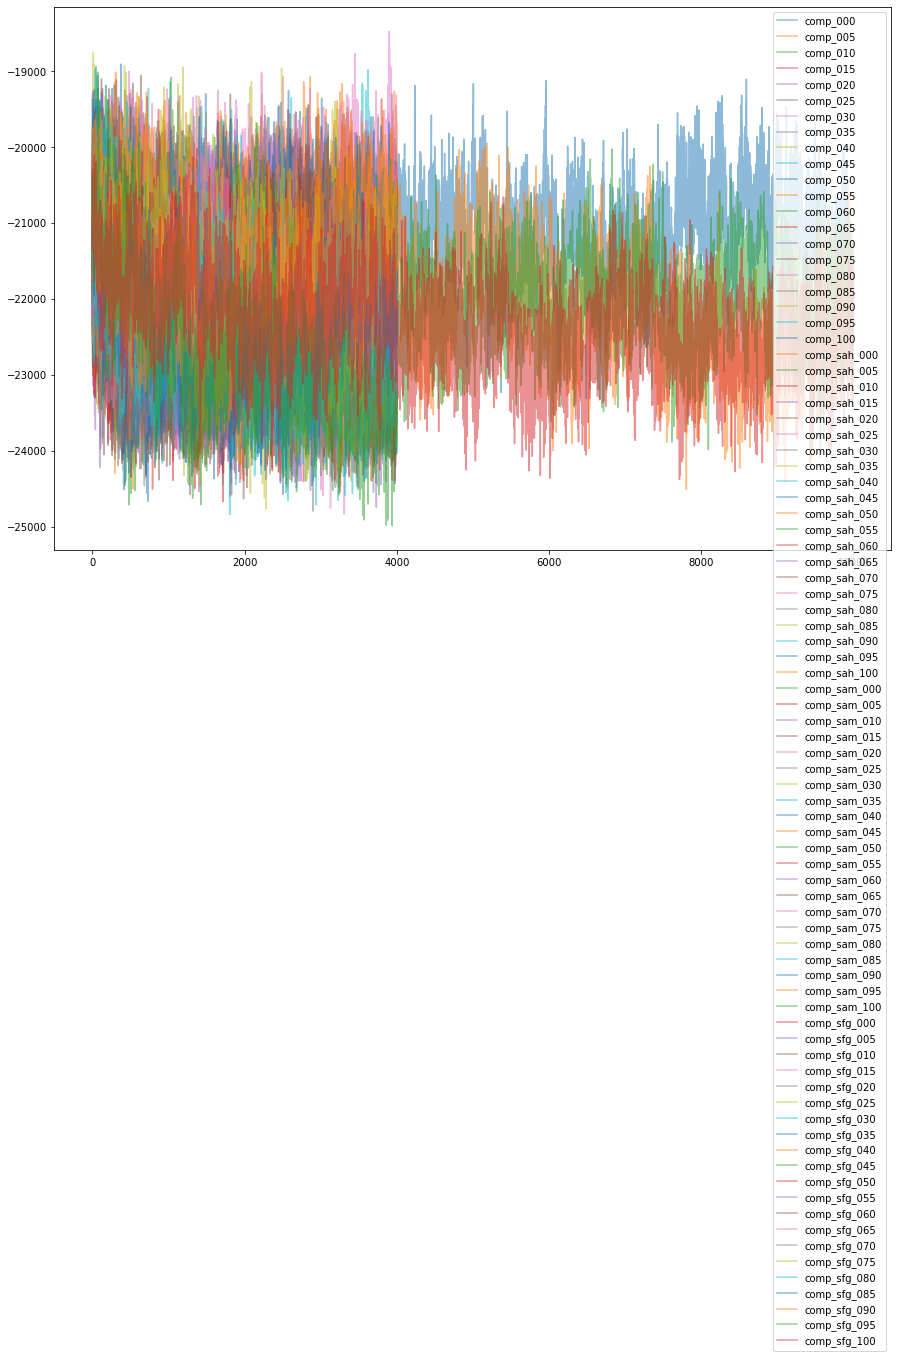

In [8]:
fig, axes = plt.subplots( figsize=(15,10)) 
n_traj = 0 

for sys_name in sorted(df.sys_name.unique()): 
    sub_df = df[df['sys_name'] == sys_name]
    if max(sub_df['total']) > 1e9: 
        print(sys_name) 
    axes.plot(sub_df['frame'], sub_df['total'], label=sys_name, alpha=.5) 
plt.legend()


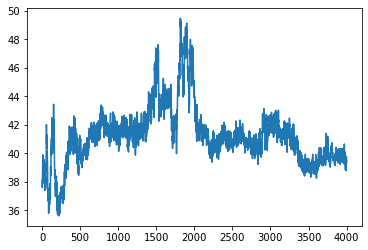

In [15]:
plt.plot(df[df['sys_name'] == 'comp_rna7jyy_072']['dist'].item())